In [10]:
from fixed_effects import run_fixed_effects_on_flattened
from random_effects import run_rand_effects_on_flattened
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
path = "./../../data/11_flattenned/flatten_variables_pct.csv"

Simple Fixed Effects

In [12]:
results_simple_fix = run_fixed_effects_on_flattened(path)
results_end_of_year_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates = ["=12/2019", "=12/2020", "=12/2021", "=12/2022", "=12/2023"], 
                                  dummy_names = ["is_END19", "is_END20", "is_END21", "is_END22", "is_END23"])
results_war_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates=[">02/2022"], 
                                  dummy_names=["is_WAR"])
results_both_fixed = run_fixed_effects_on_flattened(path,
                                  dummy_dates = ["=12/2019", "=12/2020", "=12/2021", "=12/2022", "=12/2023", ">02/2022"], 
                                  dummy_names = ["is_END19", "is_END20", "is_END21", "is_END22", "is_END23", "is_WAR"])
results_random = run_rand_effects_on_flattened(path)

lst = [(results_simple_fix, "Simp__F"), 
       (results_end_of_year_fixed, "Years_F"),
       (results_war_fixed, "War_F"),
       (results_both_fixed, "All_F"),
       (results_random, "Random")]

=============================== Fixed Effects =================================
                            OLS Regression Results                            
Dep. Variable:                    NIM   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.588
Date:                Fri, 03 May 2024   Prob (F-statistic):           3.28e-07
Time:                        17:20:10   Log-Likelihood:                 301.22
No. Observations:                 550   AIC:                            -560.4
Df Residuals:                     529   BIC:                            -469.9
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

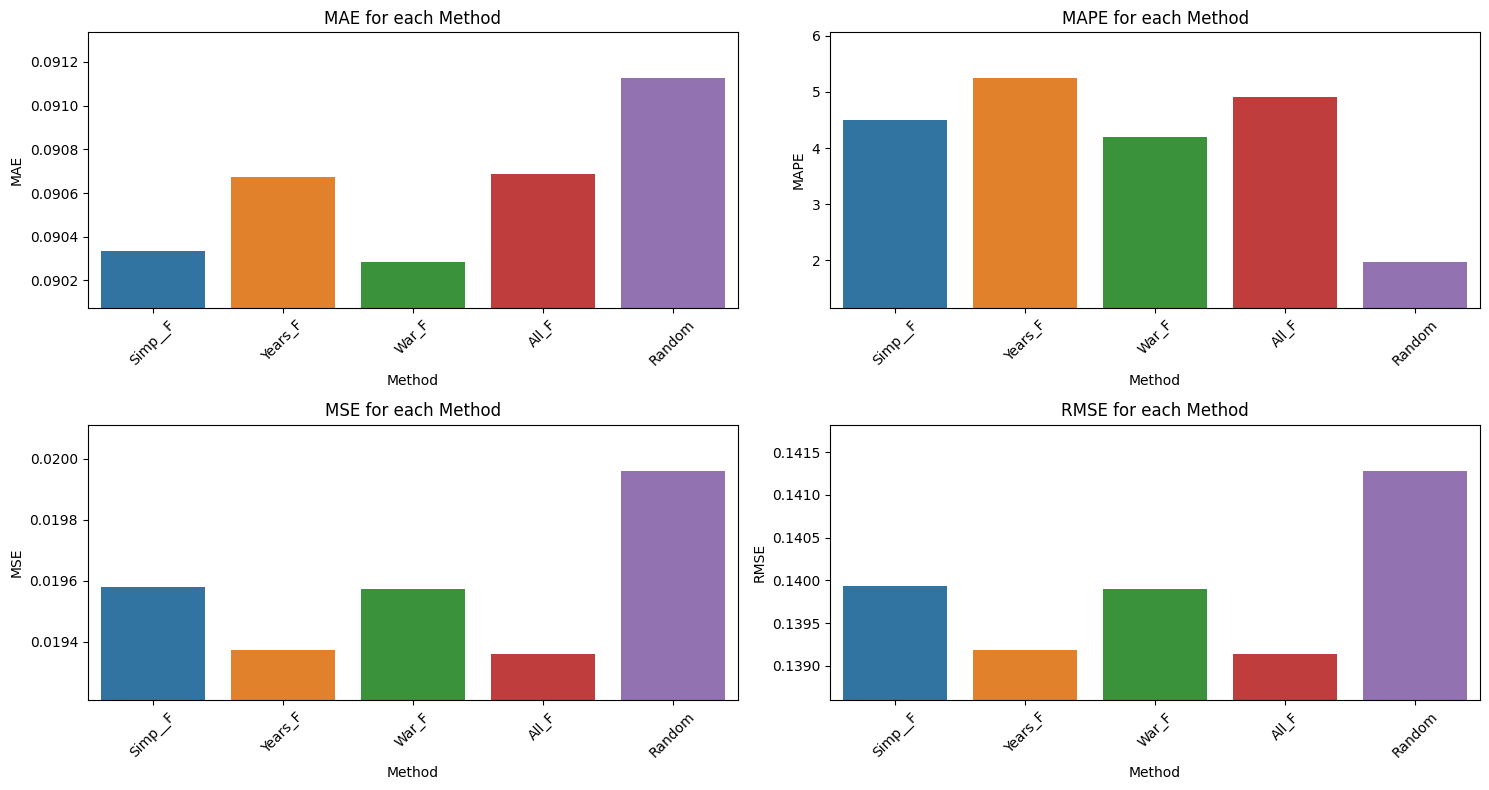

In [13]:
dct = {"Method":[], "MAE":[], "MAPE":[], "MSE":[], "RMSE":[]}

for i in lst:
    r = i[0].get_estimators(silence=True)
    dct["Method"].append(i[1])
    dct["MAE"].append(r["MAE"])
    dct["MAPE"].append(r["MAPE"])
    dct["MSE"].append(r["MSE"])
    dct["RMSE"].append(r["RMSE"])

df = pd.DataFrame(dct)
# results.style.background_gradient(cmap='Blues')

error_methods = ["MAE", "MAPE", "MSE", "RMSE"]
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

for i, error_method in enumerate(error_methods):
    ax = axs[i]
    sns.barplot(x="Method", y=error_method, data=df, ax=ax)
    ax.set_title(f"{error_method} for each Method")
    ax.set_xlabel("Method")
    ax.set_ylabel(error_method)
    ax.tick_params(axis='x', rotation=45)
    diff = (df[error_method].max() - df[error_method].min()) / 4
    ax.set_ylim(df[error_method].min() - diff, df[error_method].max() + diff)

fig.tight_layout()
plt.show()

In [14]:
# - - - F-TEST - - -
# f_h = "is_END19 = 0, is_END20 = 0, is_END21 = 0, is_END22 = 0, is_END23 = 0"
# results_end_of_year_fixed.res.f_test(f_h)

In [15]:
results_both_fixed.X.head()

,PR,CDR,LAS,CR,NIA,OE,RA,ROA,SCTA,SIZE,...,is_Raiffeisen,is_Sense,is_Ukrsibbank,is_Universal,is_END19,is_END20,is_END21,is_END22,is_END23,is_WAR
11,0.0,0.015784,-0.006186,-0.066219,0.942796,0.207098,0.078722,-0.147145,0.063573,-0.000078,...,0,0,0,0,0,0,0,0,0,0
12,0.0,-0.010351,-0.384326,-0.047214,-0.915124,-0.019262,0.023386,-0.079393,-0.024569,0.000648,...,0,0,0,0,0,0,0,0,0,0
13,0.0,-0.019367,0.049981,0.042048,2.040950,-0.020102,0.045302,0.067595,-0.093648,-0.000375,...,0,0,1,0,0,0,0,0,0,0
14,0.0,0.058076,-0.048690,-0.028533,0.650224,0.109880,0.035988,-0.062180,-0.059612,-0.001664,...,0,0,0,0,0,0,0,0,0,0
15,0.0,-0.030756,-0.109145,-0.039392,1.980223,2.639490,-0.020835,0.644816,-0.022770,0.000789,...,0,0,0,1,0,0,0,0,0,0


In [16]:
import numpy as np
from scipy.stats import chi2
def p_value_Wald_test(model):
    arr = model.X
    Ng = len(arr.columns)-1
    T = np.array([len(arr)]*Ng)  # Number of observations for each unit
    residuals = arr  # ?????????????????????????????????????????????????????
    for i in range(Ng):
        residuals.iloc[:,i]=(residuals.iloc[:,i]-np.mean(residuals.iloc[:,i]))**2
    sigma_squared_i = np.var(residuals, axis=1)
    Vi = np.zeros(Ng)
    for i in range(Ng):
        Ti = T[i]
        sigma_squared_i_hat = np.mean(residuals.iloc[:,i]**2)
        Vi[i] = (1 / (Ti * (Ti - 1))) * np.sum((residuals.iloc[:,i]**2 - sigma_squared_i_hat)**2)
    sigma_squared = np.mean(sigma_squared_i)
    W = np.sum((sigma_squared_i - sigma_squared)**2) / np.sum(Vi)
    return 1-chi2._cdf(W,Ng)
for i in lst:
    print(p_value_Wald_test(i[0]))

C:\Users\HP\AppData\Local\Temp\ipykernel_22020\2379640224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals.iloc[:,i]=(residuals.iloc[:,i]-np.mean(residuals.iloc[:,i]))**2
C:\Users\HP\AppData\Local\Temp\ipykernel_22020\2379640224.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  residuals.iloc[:,i]=(residuals.iloc[:,i]-np.mean(residuals.iloc[:,i]))**2


0.0
0.0
0.0
0.0
0.0
